# APPROACH 3

In [1]:
import sys
import os
import random as rd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
scaler = StandardScaler()

import tensorflow as tf
from tensorflow import keras


raw_data_folder = os.path.abspath('/home/siedan/programming/masterarbeit/code/analysis/raw_data')

def load_df(name):
    return pd.read_csv(os.path.join(raw_data_folder, name))

df_working = load_df('adapted_data.csv').drop(['Unnamed: 0'], axis =1)

features_year1 = ['styria_dummy', 'not_styria_dummy', 'germany_dummy',
                  'num_parallel_studies', 'years_since_matura', 'firstGen',
                  'geschlecht', 'AHS_dummy', 'BHS_dummy', 'ausland_vorbildung_dummy',
                  'sonstige_vorbildung_dummy', 'jus_dummy', 'bwl_dummy',
                  'delayed_dummy','active_3years', 'ECTS_year', 'active_dummy']

features_years = ['Studienjahr', 'styria_dummy', 'not_styria_dummy', 'germany_dummy',
                  'num_parallel_studies', 'cum_ects_pos_before', 'avgECTS_sem_before', 'ects_year_before',
                  'full_duration_sem_before', 'geschlecht', 'years_since_matura', 'firstGen', 'AHS_dummy',
                  'BHS_dummy', 'ausland_vorbildung_dummy', 'sonstige_vorbildung_dummy', 'delayed_dummy',
                  'jus_dummy', 'bwl_dummy', 'active_3years', 'ECTS_year', 'active_dummy']



## Daten:


In [2]:
df_test = df_working.copy(deep = True)

In [3]:
def active_3years(df):
    count = 0
  
    for i in range(len(df)):
        
        matrikel_number = df.loc[i, 'matrikel_num']
        studienjahr = df.loc[i, 'Studienjahr'] + 2
        jus_dummy = df.loc[i, 'jus_dummy']
        bwl_dummy = df.loc[i, 'bwl_dummy']
        
        student_in_3_years = df.query('matrikel_num == @matrikel_number and Studienjahr == @studienjahr and jus_dummy == @jus_dummy and bwl_dummy == @bwl_dummy').reset_index(drop = True)
        
        if len(student_in_3_years) != 0:
            count += 1
            active = student_in_3_years.loc[0, 'active_dummy']
            df.loc[i, 'active_3years'] = active
        else:
            df.loc[i, 'active_3years'] = 0 # mache ich auch null, weil er ja nicht aktiv ist, wenn er nicht mehr da ist.
        
        
    print(count)  
    return df







In [4]:
df_new = active_3years(df_test).query('year <= 17') # weil ich +2 rechne und ich den Datensatz nur bis 19 habe. 
# ansonsten haetten manche keine Chance!

13042


In [5]:
df1 = df_new.query('Studienjahr == 1').copy(deep = True)
df2 = df_new.query('Studienjahr > 1').copy(deep = True)


## Modelle:


In [6]:
def create_data1(df):
    df = df.query('Studienjahr == 1')[features_year1].copy(deep = True)
    df = df.dropna().reset_index(drop = True)
    split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)
    for train_index, test_index in split.split(df, df['active_3years']):
        df_train = df.loc[train_index, :]
        df_test = df.loc[test_index, :]
    df_train_copy = df_train.copy(deep = True)
    y_train = list(df_train['active_3years'])
    y_test = list(df_test['active_3years'])
    df_train = scaler.fit_transform(df_train.drop(['active_3years', 'ECTS_year', 'active_dummy'], axis = 1))
    df_test = scaler.fit_transform(df_test.drop(['active_3years', 'ECTS_year', 'active_dummy'], axis = 1))
    return df_train, y_train, df_test, y_test, df_train_copy

def create_data2(df):
    df = df.query('Studienjahr > 1')[features_years].copy(deep = True)
    df = df.dropna().reset_index(drop = True)
    split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)
    for train_index, test_index in split.split(df, df['active_3years']):
        
        df_train = df.loc[train_index, :]
        df_test = df.loc[test_index, :]
    df_train_copy = df_train.copy(deep = True)
    y_train = list(df_train['active_3years'])
    y_test = list(df_test['active_3years'])
    df_train = scaler.fit_transform(df_train.drop(['active_3years', 'ECTS_year', 'active_dummy'], axis = 1))
    df_test = scaler.fit_transform(df_test.drop(['active_3years', 'ECTS_year', 'active_dummy'], axis = 1))
    return df_train, y_train, df_test, y_test, df_train_copy


df1_train, y1_train, df1_test, y1_test, df1_train_copy = create_data1(df_new)
df2_train, y2_train, df2_test, y2_test, df2_train_copy = create_data2(df_new)

print(len(df1_train))
print(len(df2_train))

4585
6311


In [7]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard deviation: ', scores.std())

def perform_classification(classifier, df, labels):
    df = df.copy()
    print('#####')
    scores = cross_val_score(classifier, df, labels, cv=5, scoring='accuracy')
    display_scores(scores)
    
    predicted = cross_val_predict(classifier, df, labels, cv=5)
    matrix = confusion_matrix(labels, predicted)
    print(matrix)
#     plt.matshow(matrix, cmap=plt.cm.gray)
    plt.show()  
    row_sums = matrix.sum(axis=1, keepdims=True)
    norm_matrix = matrix / row_sums
    np.fill_diagonal(norm_matrix, 0)
#     plt.matshow(norm_matrix, cmap=plt.cm.gray)
    plt.show()    
    print('#####')
    return

# def perform_probability_classification(classifier, df_train, y_train, df_test, y_test):
#     classifier = sklearn.base.clone(classifier)
#     classifier.fit(df_train, y_train)
#     probabilities = classifier.predict_proba(df_test)[:,1]
#     for i in range(len(probabilities)):
#         num = rd.random()
#         if probabilities[i] >= num:
#             probabilities[i] = 1
#         else:
#             probabilities[i] = 0
            
#     print('#####')
#     matrix = confusion_matrix(y_test, probabilities)
#     print(matrix)
# #     plt.matshow(matrix, cmap=plt.cm.gray)
# #     plt.show()  
# #     row_sums = matrix.sum(axis=1, keepdims=True)
# #     norm_matrix = matrix / row_sums
# #     np.fill_diagonal(norm_matrix, 0)
# #     plt.matshow(norm_matrix, cmap=plt.cm.gray)
# #     plt.show()    
#     print('#####')
    
def probability_classification(classifier, df_train, y_train, df_test, y_test):
    classifier = sklearn.base.clone(classifier)
    classifier.fit(df_train, y_train)
    probabilities = classifier.predict_proba(df_test)[:,1]
    prediction = np.sum(probabilities)
    real_value = np.sum(y_test)
    print('Prediction: ' + str(prediction) + ' vs. Real value: ' + str(real_value))

# print(precision_score(y1_train, y1_train_predicted))
# print(recall_score(y1_train, y1_train_predicted))
# print(f1_score(y1_train, y1_train_predicted))

### Logistic Regression: 


In [8]:
from sklearn.linear_model import LogisticRegression

log_clf1 = LogisticRegression(random_state=0, multi_class = 'multinomial')
log_clf2 = LogisticRegression(random_state=0, multi_class = 'multinomial')

# perform_probability_classification(log_clf1, df1_train, y1_train, df1_test, y1_test)
# perform_probability_classification(log_clf2, df2_train, y2_train, df2_test, y2_test)

probability_classification(log_clf1, df1_train, y1_train, df1_test, y1_test)
probability_classification(log_clf2, df2_train, y2_train, df2_test, y2_test)

perform_classification(log_clf1, df1_train, y1_train)
perform_classification(log_clf2, df2_train, y2_train)



Prediction: 187.36972411079404 vs. Real value: 187.0
Prediction: 259.4939972615948 vs. Real value: 259.0
#####
Scores:  [0.62486369 0.63140676 0.64122137 0.64013086 0.63358779]
Mean:  0.6342420937840785
Standard deviation:  0.005996827517935674
[[2858   46]
 [1631   50]]
#####
#####
Scores:  [0.69833729 0.69096672 0.68066561 0.70998415 0.70126783]
Mean:  0.6962443205559175
Standard deviation:  0.009888866757310507
[[3315  666]
 [1251 1079]]
#####


### Neuronale Netzwerke:

In [9]:
model1 = keras.models.Sequential([
        keras.layers.Dense(60, activation = 'relu', input_shape = df1_train.shape[1:]),
        keras.layers.Dense(40, activation = 'relu'),
        keras.layers.Dense(20, activation = 'relu'),
        keras.layers.Dense(1, activation = 'sigmoid')
    ])

model1.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
history1 = model1.fit(df1_train, np.array(y1_train), epochs = 35, validation_split = 0.1)

predictions1 = model1.predict(df1_test)
predict1 = np.sum(predictions1)
real1 = np.sum(y1_test)
print('Prediction: ' + str(predict1) + ' vs. Real value: ' + str(real1))


model2 = keras.models.Sequential([
        keras.layers.Dense(60, activation = 'relu', input_shape = df2_train.shape[1:]),
        keras.layers.Dense(40, activation = 'relu'),
        keras.layers.Dense(20, activation = 'relu'),
        keras.layers.Dense(1, activation = 'sigmoid')
    ])
model2.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
history2 = model2.fit(df2_train, np.array(y2_train), epochs = 35, validation_split = 0.1)

predictions2 = model2.predict(df2_test)
predict2 = np.sum(predictions2)
real2 = np.sum(y2_test)
print('Prediction: ' + str(predict2) + ' vs. Real value: ' + str(real2))  



# print('#####')
# matrix = confusion_matrix(y1_test, predictions1)
# print(matrix)
# plt.matshow(matrix, cmap=plt.cm.gray)
# plt.show()  
# row_sums = matrix.sum(axis=1, keepdims=True)
# norm_matrix = matrix / row_sums
# np.fill_diagonal(norm_matrix, 0)
# plt.matshow(norm_matrix, cmap=plt.cm.gray)
# plt.show()    
# print('#####')

# print('#####')
# matrix = confusion_matrix(y2_test, predictions2)
# print(matrix)
# plt.matshow(matrix, cmap=plt.cm.gray)
# plt.show()  
# row_sums = matrix.sum(axis=1, keepdims=True)
# norm_matrix = matrix / row_sums
# np.fill_diagonal(norm_matrix, 0)
# plt.matshow(norm_matrix, cmap=plt.cm.gray)
# plt.show()    
# print('#####')

Epoch 1/35
129/129 [==============================] - 1s 2ms/step - loss: 0.6583 - accuracy: 0.6306 - val_loss: 0.6492 - val_accuracy: 0.6558
Epoch 2/35
129/129 [==============================] - 0s 1ms/step - loss: 0.6540 - accuracy: 0.6309 - val_loss: 0.6459 - val_accuracy: 0.6558
Epoch 3/35
129/129 [==============================] - 0s 1ms/step - loss: 0.6514 - accuracy: 0.6309 - val_loss: 0.6441 - val_accuracy: 0.6558
Epoch 4/35
129/129 [==============================] - 0s 1ms/step - loss: 0.6492 - accuracy: 0.6309 - val_loss: 0.6430 - val_accuracy: 0.6558
Epoch 5/35
129/129 [==============================] - 0s 1ms/step - loss: 0.6474 - accuracy: 0.6309 - val_loss: 0.6412 - val_accuracy: 0.6558
Epoch 6/35
129/129 [==============================] - 0s 1ms/step - loss: 0.6458 - accuracy: 0.6309 - val_loss: 0.6400 - val_accuracy: 0.6558
Epoch 7/35
129/129 [==============================] - 0s 1ms/step - loss: 0.6444 - accuracy: 0.6309 - val_loss: 0.6389 - val_accuracy: 0.6558
Epoch 

178/178 [==============================] - 0s 1ms/step - loss: 0.4700 - accuracy: 0.7704 - val_loss: 0.4749 - val_accuracy: 0.7642
Epoch 24/35
178/178 [==============================] - 0s 1ms/step - loss: 0.4686 - accuracy: 0.7732 - val_loss: 0.4762 - val_accuracy: 0.7563
Epoch 25/35
178/178 [==============================] - 0s 1ms/step - loss: 0.4677 - accuracy: 0.7721 - val_loss: 0.4743 - val_accuracy: 0.7674
Epoch 26/35
178/178 [==============================] - 0s 1ms/step - loss: 0.4668 - accuracy: 0.7714 - val_loss: 0.4741 - val_accuracy: 0.7706
Epoch 27/35
178/178 [==============================] - 0s 1ms/step - loss: 0.4659 - accuracy: 0.7746 - val_loss: 0.4742 - val_accuracy: 0.7674
Epoch 28/35
178/178 [==============================] - 0s 1ms/step - loss: 0.4647 - accuracy: 0.7758 - val_loss: 0.4726 - val_accuracy: 0.7627
Epoch 29/35
178/178 [==============================] - 0s 1ms/step - loss: 0.4641 - accuracy: 0.7737 - val_loss: 0.4718 - val_accuracy: 0.7706
Epoch 30/35

### Random Forest:

In [10]:
from sklearn.ensemble import RandomForestClassifier

forest_clf1 = RandomForestClassifier()
forest_clf2 = RandomForestClassifier()

# perform_probability_classification(forest_clf1, df1_train, y1_train, df1_test, y1_test)
# perform_probability_classification(forest_clf2, df2_train, y2_train, df2_test, y2_test)

probability_classification(forest_clf1, df1_train, y1_train, df1_test, y1_test)
probability_classification(forest_clf2, df2_train, y2_train, df2_test, y2_test)

perform_classification(forest_clf1, df1_train, y1_train)
perform_classification(forest_clf2, df2_train, y2_train)

Prediction: 186.46104149207088 vs. Real value: 187.0
Prediction: 267.25059523809523 vs. Real value: 259.0
#####
Scores:  [0.62050164 0.60959651 0.62159215 0.60087241 0.6259542 ]
Mean:  0.6157033805888767
Standard deviation:  0.009165496789291462
[[2336  568]
 [1195  486]]
#####
#####
Scores:  [0.72367379 0.76545166 0.73454834 0.76228209 0.74326466]
Mean:  0.7458441087491986
Standard deviation:  0.016002715249488802
[[3282  699]
 [ 907 1423]]
#####


### Support Vector Machine:

In [11]:
from sklearn.svm import SVC

svm_clf1 = SVC(kernel = 'rbf', gamma = 10, C = 100, probability = True)
svm_clf2 = SVC(kernel = 'rbf', gamma = 10, C = 100, probability = True)

# perform_probability_classification(svm_clf1, df1_train, y1_train, df1_test, y1_test)
# perform_probability_classification(svm_clf2, df2_train, y2_train, df2_test, y2_test)

probability_classification(svm_clf1, df1_train, y1_train, df1_test, y1_test)
probability_classification(svm_clf2, df2_train, y2_train, df2_test, y2_test)

perform_classification(svm_clf1, df1_train, y1_train)
perform_classification(svm_clf2, df2_train, y2_train)

Prediction: 186.0763578927803 vs. Real value: 187.0
Prediction: 262.0212810880333 vs. Real value: 259.0
#####
Scores:  [0.62922574 0.62704471 0.6346783  0.60414395 0.63576881]
Mean:  0.6261723009814613
Standard deviation:  0.011487192220077392
[[2455  449]
 [1265  416]]
#####
#####
Scores:  [0.68962787 0.70998415 0.67749604 0.70839937 0.69809826]
Mean:  0.6967211366291363
Standard deviation:  0.012116962727916987
[[3558  423]
 [1491  839]]
#####


# Problem 2 Ansatz 1 wird hier aufbereitet:
Hier geht es um die Legetimation.

In [13]:
df_beginners = df_working.query('Studienjahr == 1')
df_beginners

lengths = []
for i in [15,16,17,18,19]:
    df_dummy = df_beginners.query('year == @i')
    lengths.append(len(df_dummy))
    
lengths

[2218, 2048, 1899, 1607, 1319]

### Diese Trendanalyse ist nicht aussagekraeftig!!!!

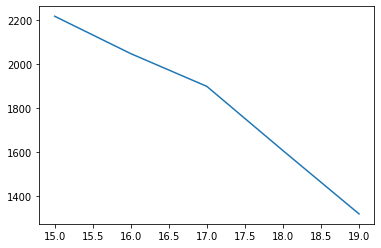

In [14]:
plt.plot([15,16,17,18,19], lengths)

In [15]:
from sklearn.linear_model import LinearRegression
years = np.array([15,16,17,18,19])
year_model = LinearRegression()
year_model.fit(years.reshape(-1,1), lengths)

predicted_years = np.array([20,21])
print(year_model.predict(predicted_years.reshape(-1,1)))
print(lengths)

[1146.5  922.6]
[2218, 2048, 1899, 1607, 1319]


In [16]:
features2years = ['Studienjahr', 'styria_dummy', 'not_styria_dummy', 'germany_dummy',
                  'num_parallel_studies', 'years_since_matura', 'firstGen',
                  'geschlecht', 'AHS_dummy', 'BHS_dummy', 'ausland_vorbildung_dummy',
                  'sonstige_vorbildung_dummy', 'jus_dummy', 'bwl_dummy',
                  'delayed_dummy','active_2years']

features1year = ['Studienjahr', 'styria_dummy', 'not_styria_dummy', 'germany_dummy',
#                   'num_parallel_studies', 'years_since_matura', 'firstGen',
                  'geschlecht', 'AHS_dummy', 'BHS_dummy', 'ausland_vorbildung_dummy',
                  'sonstige_vorbildung_dummy', 'jus_dummy', 'bwl_dummy',
#                   'delayed_dummy',
                 'active_dummy']

In [60]:
df = load_df('adapted_data.csv').drop(['Unnamed: 0'], axis =1)

def active_2years(df):
    df['active_3years'] = 0
    for i in range(len(df)):
        
        matrikel_number = df.loc[i, 'matrikel_num']
        studienjahr = df.loc[i, 'Studienjahr'] + 1
        jus_dummy = df.loc[i, 'jus_dummy']
        bwl_dummy = df.loc[i, 'bwl_dummy']
        
        student2 = df.query('matrikel_num == @matrikel_number and Studienjahr == @studienjahr and jus_dummy == @jus_dummy and bwl_dummy == @bwl_dummy').reset_index(drop = True)

        if len(student2) != 0:
            active = student2.loc[0, 'active_dummy']
            df.loc[i, 'active_2years'] = active
            
    return df

df_2years = active_2years(df)
df_2years['active_2years'].fillna(0)


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
39937    0.0
39938    0.0
39939    0.0
39940    0.0
39941    0.0
Name: active_2years, Length: 39942, dtype: float64

In [68]:
df_2years = df_2years.query('year <= 17 and Studienjahr == 1')

In [69]:
df_2years.query('year == 15')['active_2years'].value_counts()

1.0    872
0.0    649
Name: active_2years, dtype: int64

In [78]:
print(len(df_2years.query('year == 16 and active_2years >= 0')))
df_2years.query('year == 16')['active_2years'].value_counts()


1421


1.0    812
0.0    609
Name: active_2years, dtype: int64

In [71]:
df_2years.query('year == 17')['active_2years'].value_counts()

1.0    708
0.0    541
Name: active_2years, dtype: int64

In [72]:
df = load_df('adapted_data.csv').drop(['Unnamed: 0'], axis =1)
df_1year = df.copy(deep = True)
df_1year['active_dummy'].fillna(0)


0        0
1        0
2        0
3        1
4        0
        ..
39937    0
39938    0
39939    1
39940    1
39941    1
Name: active_dummy, Length: 39942, dtype: int64

In [73]:
df2years = df_2years[features2years].query('Studienjahr == 1').reset_index(drop = True).dropna()
df1year = df_1year[features1year].query('Studienjahr == 1').reset_index(drop = True).dropna()


df_train2 = df2years.drop(['active_2years'], axis = 1)
y_train2 = df2years['active_2years']

df_train1 = df1year.drop(['active_dummy'], axis = 1)
y_train1 = df1year['active_dummy']



In [74]:
svm_clf1year = SVC(kernel = 'rbf', gamma = 10, C = 100, probability = True)
svm_clf2years = SVC(kernel = 'rbf', gamma = 10, C = 100, probability = True)

svm_clf1year.fit(df_train1, y_train1)
svm_clf2years.fit(df_train2, y_train2)

SVC(C=100, gamma=10, probability=True)

In [48]:
df1_15 = df_1year.query('Studienjahr == 1 and year == 15')[features1year].drop(['active_dummy'], axis = 1).fillna(0)
df1_16 = df_1year.query('Studienjahr == 1 and year == 16')[features1year].drop(['active_dummy'], axis = 1).fillna(0)
df1_17 = df_1year.query('Studienjahr == 1 and year == 17')[features1year].drop(['active_dummy'], axis = 1).fillna(0)

df1_dummy16 = df1_15.sample(n = 2048)
df1_dummy17 = df1_16.sample(n = 1899)


In [49]:
def predict_sum(classifier, df):
    probabilities = classifier.predict_proba(df)[:,1]
    for i in range(len(probabilities)):
        num = rd.random()
        if probabilities[i] >= num:
            probabilities[i] = 1
        else:
            probabilities[i] = 0
    print(sum(probabilities))
    print('######')



In [50]:

predict_sum(svm_clf1year, df1_16)
predict_sum(svm_clf1year, df1_dummy16)
print(len(df.query('Studienjahr == 1 and year == 16 and active_dummy == 1')))
print('')

predict_sum(svm_clf1year, df1_17)
predict_sum(svm_clf1year, df1_dummy17)
print(len(df.query('Studienjahr == 1 and year == 17 and active_dummy == 1')))

1118.0
######
1105.0
######
1092

1000.0
######
984.0
######
973


In [82]:
df2_15 = df_2years.query('Studienjahr == 1 and year == 15 and active_2years >= 0')[features2years].drop(['active_2years'], axis = 1).fillna(0)
df2_16 = df_2years.query('Studienjahr == 1 and year == 16 and active_2years >= 0')[features2years].drop(['active_2years'], axis = 1).fillna(0)
df2_17 = df_2years.query('Studienjahr == 1 and year == 17 and active_2years >= 0')[features2years].drop(['active_2years'], axis = 1).fillna(0)
print(len(df2_16))
print(len(df2_17))

df2_dummy16 = df2_15.sample(n = 1421)
df2_dummy17 = df2_16.sample(n = 1249)

1421
1249


In [83]:
predict_sum(svm_clf2years, df2_16)
predict_sum(svm_clf2years, df2_dummy16)
print(len(df.query('Studienjahr == 2 and year == 17 and active_dummy == 1')))
print('')

predict_sum(svm_clf2years, df2_17)
predict_sum(svm_clf2years, df2_dummy17)
print(len(df.query('Studienjahr == 2 and year == 18 and active_dummy == 1')))

867.0
######
878.0
######
819

769.0
######
769.0
######
721


In [53]:
# df = load_df('adapted_data.csv').drop(['Unnamed: 0'], axis =1)

# features2years = ['Studienjahr', 'styria_dummy', 'not_styria_dummy', 'germany_dummy',
#                   'num_parallel_studies', 'years_since_matura', 'firstGen',
#                   'geschlecht', 'AHS_dummy', 'BHS_dummy', 'ausland_vorbildung_dummy',
#                   'sonstige_vorbildung_dummy', 'jus_dummy', 'bwl_dummy',
#                   'delayed_dummy']

# features1year = ['Studienjahr', 'styria_dummy', 'not_styria_dummy', 'germany_dummy',
# #                   'num_parallel_studies', 'years_since_matura', 'firstGen',
#                   'geschlecht', 'AHS_dummy', 'BHS_dummy', 'ausland_vorbildung_dummy',
#                   'sonstige_vorbildung_dummy', 'jus_dummy', 'bwl_dummy',
# #                   'delayed_dummy',
#                  ]


# df19 = df.query('Studienjahr == 1 and year == 19')


In [54]:
# df20 = df19.sample(n = 1146)
# df21 = df19.sample(n = 922)

# df20 = df20[features2years].fillna(0)
# df21 = df21[features1year].fillna(0)

In [55]:
# predict_sum(svm_clf2years, df20)
# predict_sum(svm_clf1year, df21)

# Ansatz 2 fuer P2:

Training der Classifier fuer Studienjahre 1 und 2 (habe nicht mehr neu hinzukommende) wie zuvor, nur mit ein bisschen weniger Features.

Danach Prediction der neu hinzukommenden in allen 72 Klassen und Prediction der Aktivitaet durch die Classifier.

# Vergleich zu Ansatz 1 fuer P2: 

Nicht wirklich moeglich, weil ich jeweils einfach keine Zeitreihenanalyse machen kann. 

Mache die 2 Legitimierungen fuer Ansatz 1.

Mache die Legitimierung fuer die leicht schlechteren Classifier von Ansatz 2. 